# **COMP551 - Miniproject 2**

In [51]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import sklearn
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.ticker import MaxNLocator

## Softmax Classifer Class

In [25]:
class SoftmaxRegression:
    
    def __init__(self, add_bias=True, folds=5):
        self.add_bias = add_bias
        self.historyW, self.history_minErrTrain, self.history_minErrVal, self.history_time=[],[],[],[]
        self.numOfFolds=folds
        self.mean_minErrTrain, self.mean_minErrVal, self.mean_time=0,0,0
        
        
    def fit(self, f, optimizer):
        minErrTraining,minErrValidation,time=0,0,0
        
        x_test, y_test, x_train, y_train=f
        N,self.C = y_train.shape
        N,self.D = x_train.shape
        self.w = np.zeros((self.D,self.C))
        
        self.w,minErrTraining,minErrValidation,time = optimizer.run(x_train,y_train,x_test,y_test,self.w,True)
        
        self.historyW.append(self.w)
        self.history_minErrTrain.append(minErrTraining)
        self.history_minErrVal.append(minErrValidation)
        self.history_time.append(time)        
        
        return self.w
    
    def softmax_loss(self,scores,y):
        p=softmax(scores)
        return -np.sum(y*np.log(p))
    
    def predict(self, x):
        yh = softmax(x@self.w)            #predict output
        return np.argmax(yh,axis=1)
    
    def endTraining(self):
        self.w = np.zeros((self.D,self.C))
        self.w=self.meanCalculation(self.w,self.historyW)
        self.mean_minErrTrain=self.meanCalculation(self.mean_minErrTrain,self.history_minErrTrain)
        self.mean_minErrVal=self.meanCalculation(self.mean_minErrVal,self.history_minErrVal)
        self.mean_time=self.meanCalculation(self.mean_time,self.history_time)
        print('Mean of performance parameters:')
        print('Mean of training error='+str(self.mean_minErrTrain))
        print('Mean of validation error='+str(self.mean_minErrVal))
        print('Mean of time='+str(self.mean_time))
        print('***************************************************')
        return self.mean_minErrTrain, self.mean_minErrVal, self.mean_time
        
    def meanCalculation(self,item,history):
        for i in range(0,len(history)):
            item = history[i]+item
        item/=self.numOfFolds
        return item
        

## Optimizer Class

In [34]:
class Optimizer:
    
    def __init__(self, learning_rate=.1, max_iters=1e5, epsilon=1e-8, mom=0.9, batchSize=32, tuning=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.mom=mom
        self.validation_err_decreasing=True
        self.batchSize=batchSize
        self.tuning=tuning
            
    def run(self,X, Y, X_validation, Y_validation, w, validation):
        start_time = time.time()
        self.w=w
        N,D=X.shape
        grad = np.inf
        numOfBatch=math.ceil(N/self.batchSize)
        delta_w=0
        t, epoch = 0,0
        self.w_history=[]
        validationLoss,trainingloss=[],[]
        trainingError,validationError=[],[]
        minibatches=self.get_minibatch(X,Y,self.batchSize)           # get all batches
        minErrValidation=1000
        minErrTraining=1000
        earlyStoppingError_train=[]
        earlyStoppingError_validation=[]
        
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters and self.validation_err_decreasing:
            x_validation,y_validation=X_validation,Y_validation
            x2grad, y2grad = minibatches[int(t%numOfBatch)]     # select the next batch from the list of batches
            grad = self.gradient(x2grad, y2grad, self.w)        # compute the gradient for the random batch with present weight
            delta_w = self.mom*delta_w + (1-self.mom)*grad
            self.w = self.w - self.learning_rate * delta_w      # weight update step
            self.w_history.append(self.w)
            earlyStoppingError_train.append(self.errorEstimation(x2grad,y2grad,self.w))
            earlyStoppingError_validation.append(self.errorEstimation(x_validation,y_validation,self.w))
            
            if(t%numOfBatch==0 and t>0):                        # end of epoch
                epoch+=1
                trainingloss.append(self.softmax_loss(x2grad,y2grad,self.w))
                trainingError.append(self.errorEstimation(x2grad,y2grad,self.w))
                
                if(validation):
                    validationLoss.append(self.softmax_loss(x_validation,y_validation,self.w))
                    validationError.append(self.errorEstimation(x_validation,y_validation,self.w))
                    self.validation_err_decreasing=self.checkValidationPattern(validationError[-20:])
                    
                    if(not self.validation_err_decreasing and t>20):
                        minErrorIndex=np.argmin(validationError[-20:])
                        minErrValidation=validationError[-20+minErrorIndex]
                        minErrTraining=trainingError[-20+minErrorIndex]                        
                        self.w=self.w_history[-20+minErrorIndex]
            t += 1
            
        if( minErrValidation==1000):
            if(len(validationError)==0):
                validationError=earlyStoppingError_validation
                trainingError=earlyStoppingError_train
            minErrValidation=validationError[-1]
            minErrTraining=trainingError[-1] 
        
        end_time = time.time()-start_time

        if(not self.tuning):
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(grad)}')
            print('minimum training error='+str(minErrTraining))
            print('minimum validation error='+str(minErrValidation))
            print('time='+str(end_time))
            #self.plotTrainValidationError(trainingloss,validationLoss,'Loss')
            self.plotTrainValidationError(trainingError,validationError,'Error')
            
        return self.w,minErrTraining,minErrValidation,end_time
    
    def gradient(self, x, y, w):
        N,D = x.shape
        yh = softmax(np.dot(x,w))           # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad

    def get_minibatch(self,x, y, batch_size):
        minibatches = []                                #an array of batches of size 'batch_size'
        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            minibatches.append((x_batch, y_batch))
        return minibatches
    
    def softmax_loss(self,x,y,w):
        p=softmax(np.dot(x,w))
        return -np.sum(y*np.log(p))
    
    def checkValidationPattern(self,validationLoss):
        if(len(validationLoss)<20):
            return True
        return not all(x<=y for x, y in zip(validationLoss, validationLoss[1:]))
                                     
    def errorEstimation(self,x,y,w):
        yh = softmax(x@w)            #predict output
        return (((y-yh)**2)/2).sum()
    
    def plotTrainValidationError(self,trainingloss,validationLoss,title):
        plt.plot(trainingloss, label = "Training ")
        plt.plot(validationLoss, label = "Validation ")
        plt.xlabel('Epoch')
        plt.ylabel(title)
        plt.title('Training vs Validation '+title)
        plt.legend()
        plt.show()

## Useful Functions

### softmax function
This function calculates the softmax values of a given matrix

In [27]:
def softmax (x):
    z=np.exp(x)
    x=np.exp(x)/np.sum(z,axis=1)[:,None]
    return x

### crossSplit Function
This function creates training and validation folds

In [28]:
def crossSplit(x,y,numOfFolds):
    N,D = x.shape
    foldSize=int(N/numOfFolds)
    crossFolds = []
    for i in range(0, N-foldSize+1, foldSize):
        x_test = x[i:i + foldSize]
        y_test = y[i:i + foldSize]
        x_train = x[i+foldSize:]
        y_train = y[i+foldSize:]
        if(i>0):
            x_train = np.concatenate((x_train, x[0:i]))
            y_train = np.concatenate((y_train, y[0:i]))
        crossFolds.append((x_test, y_test, x_train, y_train))
    return crossFolds

### onehotcoder function
This function returns a one hot matrix of the received labels

In [29]:
def onehotcoder(y):
    values = array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

## Tuning Hyperparameters - Softmax
In this part hyperparameters for Softmax classifier are tuned using a grid search. The values to be tested are: {'learning_rate': [0.1,0.01,0.001], 'momentum': [0.9,0.8,0.7], 'batchSize':[8,16,32,64]}

### First Dataset: Digits

In [30]:
#importing dataset
x, y = datasets.load_digits(return_X_y=True)

# Preprocessing
if x.ndim == 1:
    x = x[:, None]
N = x.shape[0]
x = np.column_stack([x,np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)   # choose 20% of the data for the final test
y_train=onehotcoder(y_train)
numOfFolds=5
folds=crossSplit(X_train,y_train,numOfFolds)                                                # creating 5 folds

mean_minErrTrain, mean_minErrVal, mean_time=0,0,0                                           # values to be stored for performance analysis

#creating the parameter grid
GridSearchResult = pd.DataFrame (columns = ['Learning rate','Momentum','Batch size','Mean of Training Error','Mean of Validation Error','Time'])
param_grid = {'learning_rate': [0.1,0.01,0.001], 'momentum': [0.9,0.8,0.7], 'batchSize':[8,16,32,64]}
paramList=list(ParameterGrid(param_grid))

#Start evaluating the model based on different combination of hyperparameter values
for i in paramList:
    counter=1
    lr=i['learning_rate']
    momentum=i['momentum']
    bSize=i['batchSize']
    softreg = SoftmaxRegression(folds=5)
    print('learning_rate='+str(lr))
    print('momentum='+str(momentum))
    print('batch size='+str(bSize))
    for f in folds:                     # do a five fold cross validation
        opt=Optimizer(learning_rate=lr, mom=momentum, batchSize=bSize, tuning=True) # in each fold, we create a new instance of the class Optimizer
        w=softreg.fit(f,opt)
        counter+=1
    mean_minErrTrain, mean_minErrVal, mean_time=softreg.endTraining()               # by end of training, the mean value for performance variables are returned
    new_row = {'Learning rate':lr, 'Momentum':momentum, 'Batch size':bSize,         # storing the performance value for the current hyperparameter combination
               'Mean of Training Error':mean_minErrTrain, 'Mean of Validation Error':mean_minErrVal, 'Time':mean_time}
    GridSearchResult = GridSearchResult.append(new_row, ignore_index=True)

learning_rate=0.1
momentum=0.9
batch size=8
Mean of performance parameters:
Mean of training error=2.983951069836224e-10
Mean of validation error=35.758357261578695
Mean of time=0.02921609878540039
***************************************************
learning_rate=0.1
momentum=0.8
batch size=8
Mean of performance parameters:
Mean of training error=1.93454469346063e-06
Mean of validation error=54.80232777288796
Mean of time=0.02045159339904785
***************************************************
learning_rate=0.1
momentum=0.7
batch size=8
Mean of performance parameters:
Mean of training error=3.778810048268264e-07
Mean of validation error=62.183462711343395
Mean of time=0.016807985305786134
***************************************************
learning_rate=0.01
momentum=0.9
batch size=8
Mean of performance parameters:
Mean of training error=0.01400346186011929
Mean of validation error=8.769179755070777
Mean of time=3.092121982574463
***************************************************
learn

Now that we have the performance information of every combination of hyperparameters, we will select the row that contains the lowest Mean of Validation Error as our candidate.

In [32]:
GridSearchResult=GridSearchResult.append(GridSearchResult.min(numeric_only=True), ignore_index=True)

leastMVE=GridSearchResult.iloc[-1]['Mean of Validation Error']
tunedLearningRate=GridSearchResult.loc[GridSearchResult['Mean of Validation Error']==leastMVE,'Learning rate'].iloc[0]
tunedMomentum=GridSearchResult.loc[GridSearchResult['Mean of Validation Error']==leastMVE,'Momentum'].iloc[0]
tunedBatchSize=GridSearchResult.loc[GridSearchResult['Mean of Validation Error']==leastMVE,'Batch size'].iloc[0]

print('The lowest Mean of Validation Error is :'+str(leastMVE))
print('acquired while learning rate = '+str(tunedLearningRate)+', momentum = '+str(tunedMomentum)+' and batch size = '+str(tunedBatchSize))

The lowest Mean of Validation Error is :8.027295904321704
acquired while learning rate = 0.001, momentum = 0.7 and batch size = 16.0


In [58]:
x=GridSearchResult.loc[GridSearchResult['Mean of Validation Error']==leastMVE,'Mean of Training Error'].iloc[0]
print(x)

0.053742079382573006


**Fitting the Softmax Model**

We have tuned our hyperparameters and now we can fit the model with training data using a five fold cross validation approach

Fold 1
terminated after 16129 iterations, with norm of the gradient equal to 0.5619171132798464
minimum training error=0.018287900199293123
minimum validation error=6.474013503261845
time=5.436269044876099


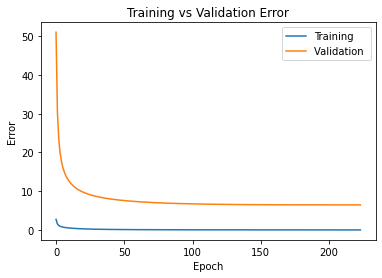

Fold 2
terminated after 54073 iterations, with norm of the gradient equal to 0.6737349530331828
minimum training error=0.018786880442953742
minimum validation error=6.455777695703041
time=16.50770330429077


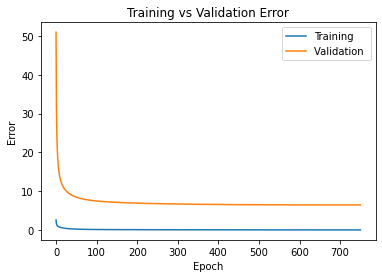

Fold 3
terminated after 35929 iterations, with norm of the gradient equal to 0.5086784091629601
minimum training error=0.008349772166502878
minimum validation error=8.974343962719935
time=10.555612564086914


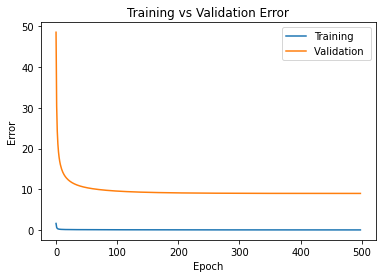

Fold 4
terminated after 20809 iterations, with norm of the gradient equal to 2.3739886382019377
minimum training error=0.15059635857677361
minimum validation error=5.527845249124602
time=6.178697347640991


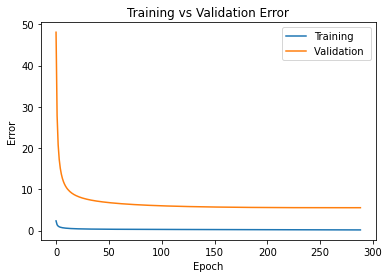

Fold 5
terminated after 9001 iterations, with norm of the gradient equal to 1.197796115223343
minimum training error=0.07268948552734164
minimum validation error=12.704499110799098
time=2.643839120864868


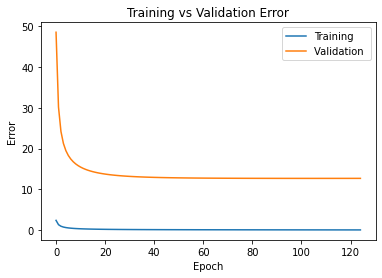

Mean of performance parameters:
Mean of training error=0.053742079382573006
Mean of validation error=8.027295904321704
Mean of time=8.264424276351928
***************************************************


(0.053742079382573006, 8.027295904321704, 8.264424276351928)

In [35]:
#loading the dataset
x, y = datasets.load_digits(return_X_y=True)

# Preprocessing
if x.ndim == 1:
    x = x[:, None]
N = x.shape[0]
x = np.column_stack([x,np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train=onehotcoder(y_train)

numOfFolds=5
folds=crossSplit(X_train,y_train,numOfFolds)
counter=1

softreg = SoftmaxRegression(folds=5)
for f in folds:
    print('Fold '+str(counter))
    opt=Optimizer(learning_rate=tunedLearningRate, mom=tunedMomentum, batchSize=int(tunedBatchSize), tuning=False)
    w=softreg.fit(f,opt)
    counter+=1
softreg.endTraining()

**Testing the Softmax Model**

The model is fitted with training data. Let's test its accuracy using unseen data.

In [36]:
yh=softreg.predict(X_test)
print('Model accuracy is :'+'%.2f'%accuracy_score(y_test, yh))

Model accuracy is :0.97


### Second Dataset: Vehicles
Same process is done for the second dataset

In [39]:
#dataset 2
from sklearn.utils import shuffle

scaler = MinMaxScaler()
df=pd.read_csv('vehicle.csv', sep=',')
df = shuffle(df)

# Preprocessing
df = df.astype({"Class":'category'})
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x[:] = scaler.fit_transform(x[:])
y = y.cat.codes

if x.ndim == 1:
    x = x[:, None]
N = x.shape[0]
x = np.column_stack([x,np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train=onehotcoder(y_train)
numOfFolds=5
folds=crossSplit(X_train,y_train,numOfFolds)

mean_minErrTrain, mean_minErrVal, mean_time=0,0,0
GridSearchResult2 = pd.DataFrame (columns = ['Learning rate','Momentum','Batch size','Mean of Training Error',
                                                  'Mean of Validation Error','Time'])

param_grid = {'learning_rate': [0.1,0.01,0.001], 'momentum': [0.9,0.8,0.7], 'batchSize':[8,16,32,64]}
paramList=list(ParameterGrid(param_grid))

for i in paramList:
    counter=1
    lr=i['learning_rate']
    momentum=i['momentum']
    bSize=i['batchSize']
    softreg = SoftmaxRegression(folds=5)
    print('learning_rate='+str(lr))
    print('momentum='+str(momentum))
    print('batch size='+str(bSize))
    for f in folds:
        opt=Optimizer(learning_rate=lr, mom=momentum, batchSize=bSize, tuning=True)
        w=softreg.fit(f,opt)
        counter+=1
    mean_minErrTrain, mean_minErrVal, mean_time=softreg.endTraining()
    new_row = {'Learning rate':lr, 'Momentum':momentum, 'Batch size':bSize,
               'Mean of Training Error':mean_minErrTrain, 'Mean of Validation Error':mean_minErrVal, 'Time':mean_time}
    GridSearchResult2 = GridSearchResult2.append(new_row, ignore_index=True)

learning_rate=0.1
momentum=0.9
batch size=8
Mean of performance parameters:
Mean of training error=1.203174065927787
Mean of validation error=19.479875566939775
Mean of time=12.196096324920655
***************************************************
learning_rate=0.1
momentum=0.8
batch size=8
Mean of performance parameters:
Mean of training error=1.1888293123500726
Mean of validation error=19.431414188656905
Mean of time=13.32831106185913
***************************************************
learning_rate=0.1
momentum=0.7
batch size=8
Mean of performance parameters:
Mean of training error=1.1797221727785492
Mean of validation error=19.403345511627304
Mean of time=12.236554813385009
***************************************************
learning_rate=0.01
momentum=0.9
batch size=8
Mean of performance parameters:
Mean of training error=1.4431302867091447
Mean of validation error=25.97279658297585
Mean of time=12.130016183853149
***************************************************
learning_rate=0.01

Now that we have the performance information of every combination of hyperparameters, we will select the row that contains the lowest Mean of Validation Error as our candidate.

In [40]:
GridSearchResult2=GridSearchResult2.append(GridSearchResult2.min(numeric_only=True), ignore_index=True)

leastMVE2=GridSearchResult2.iloc[-1]['Mean of Validation Error']
tunedLearningRate2=GridSearchResult2.loc[GridSearchResult2['Mean of Validation Error']==leastMVE2,'Learning rate'].iloc[0]
tunedMomentum2=GridSearchResult2.loc[GridSearchResult2['Mean of Validation Error']==leastMVE2,'Momentum'].iloc[0]
tunedBatchSize2=GridSearchResult2.loc[GridSearchResult2['Mean of Validation Error']==leastMVE2,'Batch size'].iloc[0]

print('The least Mean of Validation Error is :'+str(leastMVE2))
print('acquired while learning rate = '+str(tunedLearningRate2)+
      ', momentum = '+str(tunedMomentum2)+' and batch size = '+str(tunedBatchSize2))

The least Mean of Validation Error is :19.27650515437797
acquired while learning rate = 0.1, momentum = 0.9 and batch size = 64.0


In [57]:
x=GridSearchResult2.loc[GridSearchResult2['Mean of Validation Error']==leastMVE2,'Mean of Training Error'].iloc[0]
print(x)

8.071859671494906


**Fitting the Softmax Model**

We have tuned our hyperparameters and now we can fit the model with training data using a five fold cross validation approach

Fold 1
terminated after 100000 iterations, with norm of the gradient equal to 0.12895982892639035
minimum training error=8.943551395193285
minimum validation error=19.589820077794005
time=17.353994846343994


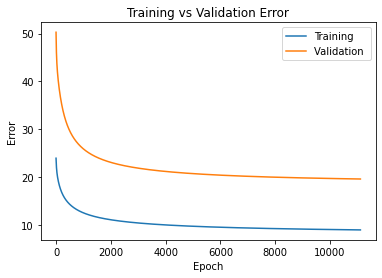

Fold 2
terminated after 100000 iterations, with norm of the gradient equal to 0.11874824365687252
minimum training error=8.508300960282984
minimum validation error=23.17480559523839
time=17.371674060821533


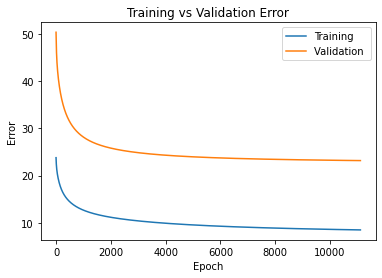

Fold 3
terminated after 100000 iterations, with norm of the gradient equal to 0.1364850446901629
minimum training error=11.43079238019348
minimum validation error=20.204387521468107
time=17.329921007156372


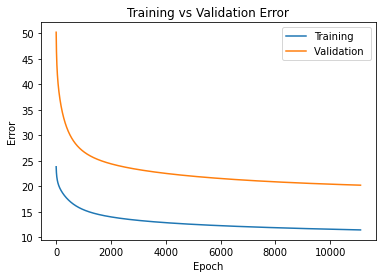

Fold 4
terminated after 100000 iterations, with norm of the gradient equal to 0.07177256124251098
minimum training error=9.721465181140738
minimum validation error=21.787810864055917
time=17.61085033416748


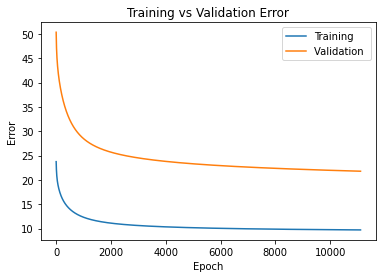

Fold 5
terminated after 100000 iterations, with norm of the gradient equal to 0.11906295211007946
minimum training error=7.520562762843003
minimum validation error=18.143075166082824
time=17.513060331344604


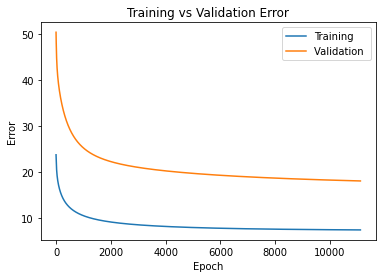

Mean of performance parameters:
Mean of training error=9.224934535930696
Mean of validation error=20.57997984492785
Mean of time=17.435900115966795
***************************************************


(9.224934535930696, 20.57997984492785, 17.435900115966795)

In [41]:
from sklearn.utils import shuffle

scaler = MinMaxScaler()
df=pd.read_csv('vehicle.csv', sep=',')
df = shuffle(df)

df = df.astype({"Class":'category'})
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x[:] = scaler.fit_transform(x[:])
y = y.cat.codes

# Preprocessing
if x.ndim == 1:
    x = x[:, None]
N = x.shape[0]
x = np.column_stack([x,np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
numOfFolds=5
y_train=onehotcoder(y_train)

folds=crossSplit(X_train,y_train,numOfFolds)
counter=1
w_history=[]

softreg2 = SoftmaxRegression(folds=5)
for f in folds:
    print('Fold '+str(counter))
    opt=Optimizer(learning_rate=tunedLearningRate2, mom=tunedMomentum2, batchSize=int(tunedBatchSize2), tuning=False)
    w=softreg2.fit(f,opt)
    counter+=1
softreg2.endTraining()

**Testing the Softmax Model**

The model is fitted with training data. Let's test its accuracy using unseen data.

In [42]:
yh=softreg2.predict(X_test)
print('Model accuracy is :'+'%.2f'%accuracy_score(y_test, yh))

Model accuracy is :0.79


### Plotting performance variables changes over hyperparameter
This function plots a scatter plot of mean of validation error changing over the selected hyperparameter

In [43]:
def plotHyperParams(param,gridResult):
    np.random.seed(19680801)
    N = 37
    x = gridResult[param]
    y = gridResult['Mean of Validation Error']
    colors = np.random.rand(N)
    area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

    plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.xlabel(param)
    plt.ylabel('Mean of Validation Error')
    plt.title('Mean of Validation Error changing over '+param)
    plt.legend()
    plt.show()

Here we use the plotHyperParams function to plot how mean of validation error changes over Learning rate, Momentum and Batch size.

No handles with labels found to put in legend.


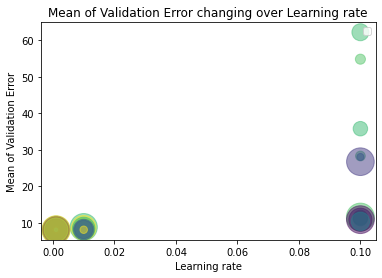

No handles with labels found to put in legend.


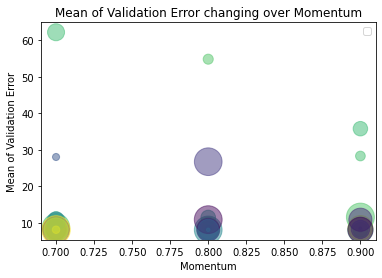

No handles with labels found to put in legend.


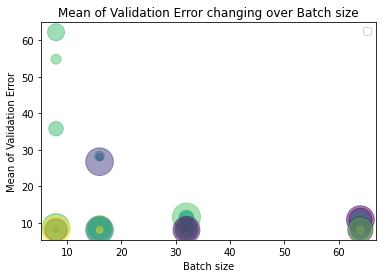

In [44]:
for param in ['Learning rate','Momentum','Batch size']:
    plotHyperParams(param,GridSearchResult)

No handles with labels found to put in legend.


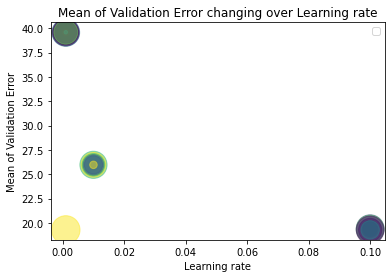

No handles with labels found to put in legend.


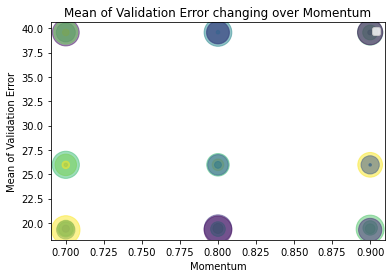

No handles with labels found to put in legend.


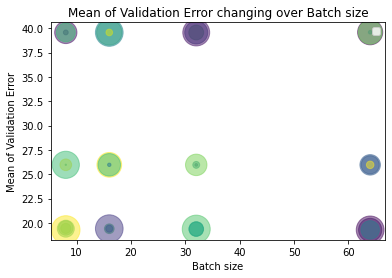

In [45]:
for param in ['Learning rate','Momentum','Batch size']:
    plotHyperParams(param,GridSearchResult2)

## KNN Classifier
In this section we provide a knn classifier that plots K changing over mean absolute error of the model

In [52]:
class knnClassifier:
    
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.k=self.findBestK()
        print('K is tuned to be: '+str(self.k))
        return
    
    def getBestK(self):
        return self.k
    
    #function to calculate mean absoloute error for the specified train and test 
    def score(self):
        model = KNeighborsClassifier(n_neighbors = self.k)
        model.fit(self.x_train,self.y_train)
        y_pred=model.predict(self.x_test)
        return metrics.mean_absolute_error(y_test, y_pred)  
    
    #function to find an array of mean absolute errors for each k in range(1,maxK)
    def errorEstimation(self,maxK):
        scores=[]
        k2test=list(range(1,maxK))
        for i in k2test:
            self.k=i
            sc=self.score()
            scores.append(sc)
        return scores
    
    #function to find best K if we split data based on date
    def findBestK(self):
        maxK=50
        meanErr=self.errorEstimation(maxK)
        
        ax = plt.figure().gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.suptitle('MAE values changing over K')
        plt.xlabel('K value')
        plt.ylabel('MAE values')
        plt.legend()
        plt.plot(list(range(1,maxK)),meanErr,'b')
        plt.show()
        return meanErr.index(min(meanErr))+1

### First Dataset: digits
Using the predefined knn classifier class, we will use 80% of the first dataset in a five fold cross validation format to fit the model. 

No handles with labels found to put in legend.


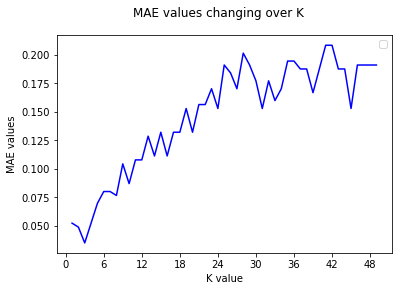

K is tuned to be: 3
Fold 1
Accuracy = 0.9965156794425087
Fold 2
Accuracy = 0.975609756097561
Fold 3
Accuracy = 0.975609756097561
Fold 4
Accuracy = 0.9965156794425087
Fold 5
Accuracy = 0.9825783972125436
Mean of Accuracy for 5 folds = 0.9853658536585368
time spent: 3.806335687637329


In [53]:
#KNNClassifier:
#first dataset
start_time = time.time()
x, y = datasets.load_digits(return_X_y=True)

# Preprocessing
if x.ndim == 1:
    x = x[:, None]
N = x.shape[0]
x = np.column_stack([x,np.ones(N)])

X_train, x_final_test, y_train, y_final_test = train_test_split(x, y, test_size=0.2, random_state=42)
numOfFolds=5

x=X_train
y=y_train

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

folds=crossSplit(x,y,numOfFolds)
counter=1
meanOfAcc=0

model = knnClassifier(X_train, X_test, y_train, y_test)
bestK = model.getBestK()

for f in folds:
    print('Fold '+str(counter))
    x_test, y_test, x_train, y_train = f
    model = KNeighborsClassifier(n_neighbors = bestK)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    acc=metrics.accuracy_score(y_test, y_pred)
    print('Accuracy = '+str(acc))
    meanOfAcc+=acc
    counter+=1
    
meanOfAcc/=numOfFolds
print('Mean of Accuracy for '+str(numOfFolds)+' folds = '+str(meanOfAcc))
end_time = time.time()-start_time
print('time spent: '+str(end_time))

Now that KNN is fitted with the training data of the first dataset, we will test the model using the unseen test data.

In [54]:
model = KNeighborsClassifier(n_neighbors = bestK)
model.fit(x,y)
y_pred=model.predict(x_final_test)
acc=metrics.accuracy_score(y_final_test, y_pred)
print('Accuracy for unseen data is: '+str(acc))

Accuracy for unseen data is: 0.9833333333333333


### Second Dataset: vehicles
Again, using the predefined knn classifier class, we will use 80% of the second dataset in a five fold cross validation format to fit the model. 

No handles with labels found to put in legend.


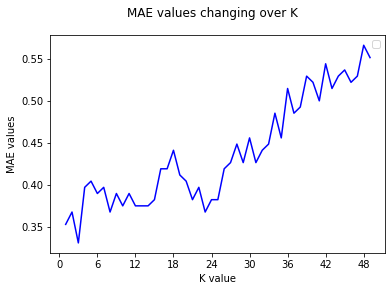

K is tuned to be: 3
Fold 1
Accuracy = 0.6888888888888889
Fold 2
Accuracy = 0.6888888888888889
Fold 3
Accuracy = 0.6888888888888889
Fold 4
Accuracy = 0.7407407407407407
Fold 5
Accuracy = 0.7555555555555555
Mean of Accuracy for 5 folds = 0.7125925925925924
time spent: 0.6916458606719971


In [55]:
#KNNClassifier:
#Second dataset
start_time = time.time()
from sklearn.utils import shuffle

scaler = MinMaxScaler()
df=pd.read_csv('vehicle.csv', sep=',')
df = shuffle(df)

df = df.astype({"Class":'category'})
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x[:] = scaler.fit_transform(x[:])
y = y.cat.codes

# Preprocessing
if x.ndim == 1:
    x = x[:, None]
N = x.shape[0]
x = np.column_stack([x,np.ones(N)])

X_train, x_final_test, y_train, y_final_test = train_test_split(x, y, test_size=0.2, random_state=42)
numOfFolds=5

x=X_train
y=y_train

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

folds=crossSplit(x,y,numOfFolds)
counter=1
meanOfAcc=0

model = knnClassifier(X_train, X_test, y_train, y_test)
bestK = model.getBestK()

for f in folds:
    print('Fold '+str(counter))
    x_test, y_test, x_train, y_train = f
    model = KNeighborsClassifier(n_neighbors = bestK)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    acc=metrics.accuracy_score(y_test, y_pred)
    print('Accuracy = '+str(acc))
    meanOfAcc+=acc
    counter+=1
    
meanOfAcc/=numOfFolds
print('Mean of Accuracy for '+str(numOfFolds)+' folds = '+str(meanOfAcc))
end_time = time.time()-start_time
print('time spent: '+str(end_time))

Now that KNN is fitted with the training data of the first dataset, we will test the model using the unseen test data.

In [56]:
model = KNeighborsClassifier(n_neighbors = bestK)
model.fit(x,y)
y_pred=model.predict(x_final_test)
acc=metrics.accuracy_score(y_final_test, y_pred)
print('Accuracy for unseen data is: '+str(acc))

Accuracy for unseen data is: 0.6882352941176471
